In [273]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats.mstats import winsorize
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy.optimize import minimize
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

# Dynamic fee algorithm

"token1": {
          "decimals": "18",
          "symbol": "WETH"
        },
"token0": {
  "decimals": "6",
  "symbol": "USDC"
},

amount0: how many of USDC the pool received during this swap 

amount1: how many of WETH the pool received during this swap

if amount1 is positive, it means the pool received a sell order of WETH.

if amount1 is negative, it means the pool received a buy order of WETH.

In [274]:
df = pd.concat([pd.read_pickle('data/Merged_CEX_DEX_v2_p1.pkl'), pd.read_pickle('data/Merged_CEX_DEX_v2_p2.pkl'), pd.read_pickle('data/Merged_CEX_DEX_v2_p3.pkl')],axis=0)
df.drop_duplicates(inplace=True)
df.set_index('time_dex', inplace=True)

In [275]:
def zscore(series):
    return (series - series.mean()) / series.std()

# # based on the trade direction 
# def calculate_fee_direction(row):
#     return (row['f_buy'] if row['amount1'] < 0 else row['f_sell'])*row['amountUSD']/100 + 0.05


# # run after fee_directional is calculated, in USD
# # TODO: minus gas
# def calculate_arbitrageur_profit_dynamic(row):
#     return row['LVR'] - row['dynamic_fee'] - row['tcost_usd']


# divide by notional amount -- percentage profits
# pool_fee is kept
def calculate_arbitrageur_profit_fixed(row):
    return (row['LVR'] - row['tcost_usd'])/row['amountUSD']


def calc_notional_profit(row):
    return row['LVR'] - row['tcost_usd']

# in percentage
# TODO ????
# def calculate_price_impact(row):
#     k = (row['amount0']/row['amount1']).abs()
    
#     return row['price_dex']*row['amount1']


# def calculate_impermanent_loss(row):
#     return row['impermanent_loss']*row['amountUSD']



In [276]:
f_min= 0.01
f_max = 0.3
# the steeper w is, the larger delta p is punished
# w = (f_max - f_min)/np.abs(df['delta_p']).mean()
w = 0.1

a=49.82
b=44.13
c=-67.72

print(f'w is {w: .3f}')

df['pool_fee'] = df['amountUSD']*0.05/100
df['delta_p'] = zscore(df['price_cex']-df['price_dex'])

# in USD
df['arb_profit_fixed'] =  df.apply(lambda row: calculate_arbitrageur_profit_fixed(row), axis=1)
# before subtracting fee
df['notional_profit'] = df.apply(lambda row: calc_notional_profit(row), axis=1)

# assume arb makes positive profits, and trade with bigger price difference
condition_is_noise = (df['delta_p'] > -2) & (df['delta_p'] < 2) & (df['arb_profit_fixed'] < 0)
df['is_arb'] = ~condition_is_noise
# in %
# df['price_impact'] = (df['price_dex'].pct_change(1).shift(-1)*100).fillna(method='bfill').fillna(method='ffill')
# df['impermanent_loss'] = (2 * np.sqrt(df['price_dex'].shift(1) / df['price_dex']) / (1 + df['price_dex'].shift(1) / df['price_dex']) - 1).fillna(0)
# # in USD
# df['impermanent_loss'] = df.apply(lambda row: calculate_impermanent_loss(row),axis=1)
df

w is  0.100


,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,time_cex,LVR_clean,LVR_clean_cumm,LVR,LVR_cumm,pool_fee,delta_p,arb_profit_fixed,notional_profit,is_arb
time_dex,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:23,18096.796543,-7.930474,18076.269412,0xe743a49f04f2f77eb2d3b753ae3ad599de8cea84,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x4fd39c9e151e50580779bd04b1f7ecc310079fd3,1.704067e+09,427523,1.358341e+10,1.358341e-08,...,2024-01-01 00:00:12.962,0.311318,0.311318,-2.468898,2.468898e+00,9.038135,0.154395,-0.000869,-15.714460,False
2024-01-01 00:00:23,700.000000,-0.306764,699.212694,0xa1179a0b94e53ee82b77c6d24c2cf67a656c2503,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704067e+09,312000,1.438341e+10,1.438341e-08,...,2024-01-01 00:00:12.962,0.311318,0.622636,-0.095501,2.564399e+00,0.349606,0.154395,-0.014776,-10.331225,False
2024-01-01 00:00:47,25000.000000,-10.955150,24971.093893,0x9b4306e7b6ede125b5e8cac309ffb58af5eed6f0,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,223193,1.259051e+10,1.259051e-08,...,2024-01-01 00:00:35.850,1.583230,2.205866,-17.344522,1.990892e+01,12.485547,0.724286,-0.000951,-23.754694,False
2024-01-01 00:00:59,767.722283,-0.336412,766.824534,0xc10527cdbc055b7f9a8a4ad765b287190c861c51,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,247124,1.230578e+10,1.230578e-08,...,2024-01-01 00:00:35.850,1.583230,3.789096,-0.532617,2.044154e+01,0.383412,0.724286,-0.009741,-7.469587,False
2024-01-01 00:01:23,170.905965,-0.074890,170.706032,0xf468072ca8f81e11655c252a37317e814b24872b,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0xa9cffe466ba8a72707d1104de239c9ab477e2493,1.704067e+09,2673946,1.443436e+10,1.443436e-08,...,2024-01-01 00:01:08.214,0.533230,4.322326,-0.039934,2.048147e+01,0.085353,0.253825,-0.515993,-88.083121,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 23:59:23,-2280.293805,1.000000,2280.074254,0x1b0cae4374ebc96289d8dab50eeffc20d3528503,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x1b0cae4374ebc96289d8dab50eeffc20d3528503,1.706746e+09,284804,3.171776e+10,3.171776e-08,...,2024-01-31 23:59:08.297,-0.053014,195902.785648,-0.053014,8.684891e+06,1.140037,-0.008847,-0.009062,-20.663160,False
2024-01-31 23:59:47,15000.000000,-6.571360,14990.873565,0xcf99f91f0d834f26b8e7267ee99203bef3648edd,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706746e+09,280947,2.010458e+10,2.010458e-08,...,2024-01-31 23:59:26.240,-0.003014,195902.788663,0.019807,8.684891e+06,7.495437,0.013556,-0.000858,-12.867196,False
2024-01-31 23:59:59,164318.889753,-71.961440,164190.258312,0x1fd0c666094d8c5dae247aa6c3c4c33fd21bdc91,0xe37e799d5077682fa0a244d46e5649f71457bd09,0xe37e799d5077682fa0a244d46e5649f71457bd09,1.706746e+09,1673514,2.378692e+10,2.378692e-08,...,2024-01-31 23:59:26.240,-1.600587,195904.389250,115.180579,8.685006e+06,82.095129,-0.702250,0.000148,24.293104,True


f_sell is systematically higher than f_buy because Price on Dex is higher than Price on CEX 

In [277]:
len(df[df['is_arb']==True])/len(df)

0.03645307567818744

# calibrate $\omega$ on buy and sell side
## delta_p and Arb Profit
### linear Regression

In [278]:
# profit % kept by arbitrageur after dynamic fee
# intercept_constant = 0.001
intercept_constant = 0.001
f_min=0.0001
f_max=0.003

# in %
def calc_f_dynamic(row, f_min, f_max, intercept_constant):
    return min(f_max, f_min + max(0, row['f_dynamic_no_bound']-intercept_constant))
def calc_uv3_notional_profit(row):
    return row['notional_profit']-0.0005*row['amountUSD']
def calc_damm_notional_profit(row):
    return row['notional_profit'] - row['f_dynamic']*row['amountUSD']
# in USD 
def calc_damm_fee(row):
    return row['f_dynamic']*row['amountUSD']

Arbitrageur txs percentage: 3.0850%
OLS Model Parameters:
  Slope: 0.0009
  Intercept: -0.0003


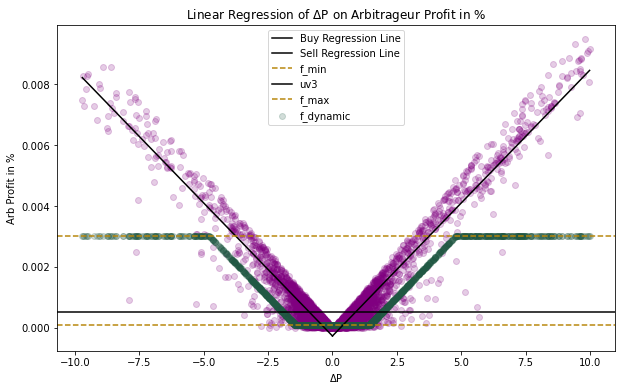

In [279]:

df_winsorize = df[(df['delta_p'] >= -10) & (df['delta_p'] <= 10) & (df['arb_profit_fixed'] >= 0) & (df['arb_profit_fixed'] <= 100)][['delta_p','arb_profit_fixed','amountUSD', 'notional_profit']].reset_index(drop=True)
# df_winsorize['notional_profit'] = df_winsorize.apply(lambda row: row['arb_profit_fixed']*row['amountUSD'], axis=1)
delta_mean = df_winsorize['delta_p'].mean()
# keep the index of sell orders, and convert delta_p to positive
index_sell = df_winsorize[df_winsorize['delta_p']<0].index
df_winsorize['delta_p'] = df_winsorize['delta_p'].abs()

X, y = df_winsorize['delta_p'].values.reshape(-1,1), df_winsorize['arb_profit_fixed']

print(f"Arbitrageur txs percentage: {len(df_winsorize)/len(df)*100:.4f}%")
model_ols = LinearRegression()
model_ols.fit(X, y)
y_pred = model_ols.predict(X)

print("OLS Model Parameters:")
print(f"  Slope: {model_ols.coef_[0]:.4f}")
print(f"  Intercept: {model_ols.intercept_:.4f}")


df_winsorize.loc[index_sell, 'delta_p'] = -df_winsorize.loc[index_sell, 'delta_p']
df_winsorize['f_dynamic_no_bound'] = np.array(y_pred)
df_winsorize['f_dynamic'] = df_winsorize.apply(lambda row: calc_f_dynamic(row, f_min, f_max, intercept_constant), axis=1)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='purple', alpha=0.2)
plt.xlabel("$\Delta$P")
plt.ylabel("Arb Profit in %")
plt.title("Linear Regression of $\Delta$P on Arbitrageur Profit in %")

line_x_buy = np.array([0, X.max()])
line_y_buy = model_ols.coef_[0] * line_x_buy + model_ols.intercept_
plt.plot(line_x_buy, line_y_buy, color='black', label='Buy Regression Line')

line_x_sell = np.array([X.min(), 0])
line_y_sell = model_ols.coef_[0] * line_x_sell * (-1) + model_ols.intercept_
plt.plot(line_x_sell, line_y_sell, color='black', label='Sell Regression Line')

plt.axhline(y=f_min, label='f_min', color='#B8860B', linestyle='--')
plt.axhline(y=0.0005, label='uv3', color='black')
plt.axhline(y=f_max, label='f_max',color='#B8860B', linestyle='--')

# plt.plot(line_x_sell, line_y_sell-intercept_constant, color='#228B22', label='f_sell')
# plt.plot(line_x_buy, line_y_buy-intercept_constant, color='#228B22', label='f_buy')
plt.scatter(X, df_winsorize['f_dynamic'], color='#205843', alpha=0.2, label="f_dynamic")

plt.legend()
plt.show()



In [280]:
def analyze_profit_redistribution(df_winsorize):
    condition_ratio_2 = (df_winsorize['delta_p'] >= -2) & (df_winsorize['delta_p'] <= 2)
    tx_ratio_2 = df_winsorize[condition_ratio_2]
    tx_outside_2 = df_winsorize[~condition_ratio_2]
    tx_ratio_5 = df_winsorize[(df_winsorize['delta_p'] >= -5) & (df_winsorize['delta_p'] <= 5)]
    avg_profit_ratio_2 = tx_ratio_2['arb_profit_fixed'].mean()
    avg_profit_ratio_5 = tx_ratio_5['arb_profit_fixed'].mean()

    print(f"{len(tx_ratio_5)/len(df_winsorize)*100:.4f}% of trades happen between ΔP in [-5,5], and Average Profits within ΔP [-5,5]: {avg_profit_ratio_5:.4f}")
    print(f"{len(tx_ratio_2)/len(df_winsorize)*100:.4f}% of trades happen between ΔP in [-2,2], and Average Profits within ΔP [-2,2]: {avg_profit_ratio_2:.4f}")

    # notional profits for ΔP in [-2,2]
    avg_notional_uv3_ratio_2 = tx_ratio_2.apply(lambda row: calc_uv3_notional_profit(row), axis=1)
    avg_notional_damm_ratio_2 = tx_ratio_2.apply(lambda row: calc_damm_notional_profit(row), axis=1)
    # profits for ΔP outside of [-2,2], AKA large price difference
    avg_notional_uv3_outside_2 = tx_outside_2.apply(lambda row: calc_uv3_notional_profit(row), axis=1)
    avg_notional_damm_outside_2 = tx_outside_2.apply(lambda row: calc_damm_notional_profit(row), axis=1)

    # Using f-string for formatting the output
    print(f"{'':<20} {'UV3':<20} {'DAMM':<20}")
    print(f"{'------------------':<20} {'------------------':<20} {'------------------':<20}")
    print(f"{'Arbitrageur Profit':<20} {avg_notional_uv3_outside_2.sum():<20} {avg_notional_damm_outside_2.sum():<20}")
    print(f"{'Noise Trader Profit':<20} {avg_notional_uv3_ratio_2.sum():<20} {avg_notional_damm_ratio_2.sum():<20}")

    # Categories and data
    categories = ['Noise Traders', 'Arbitrageurs']
    values1 = [avg_notional_uv3_ratio_2.sum(), avg_notional_uv3_outside_2.sum()]  # Values for the first group in each category
    values2 = [avg_notional_damm_ratio_2.sum(), avg_notional_damm_outside_2.sum()]  # Values for the second group in each category

    # Bar settings
    width = 0.35
    ind = np.arange(len(categories))

    # Setting up the figure and axes for two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

    # First subplot
    bars1 = ax1.bar(ind - width/2, values1, width, label='UV3 Fixed Fee', color='#B69088')
    bars2 = ax1.bar(ind + width/2, values2, width, label='Dynamic Fee', color='#205843')

    # Labels, title, and legend for the first subplot
    ax1.set_ylabel('Profits in $')
    ax1.set_title('Profits Redistribution Before and After Dynamic Fee')
    ax1.set_xticks(ind)
    ax1.set_xticklabels(categories)
    ax1.legend()

    # Second subplot data re-arrangement
    categories = ['UV3', 'DAMM']
    groups = ['Noise Traders', 'Arbitrageurs']

    # Second subplot
    bars1 = ax2.bar(ind, values1, width, label=groups[0], color='#B69088')
    bars2 = ax2.bar(ind, values2, width, bottom=values1, label=groups[1], color='#205843')  # Stacked bars

    # Adding text annotations in the second subplot
    for i in range(len(categories)):
        ax2.text(ind[i], values1[i] / 2, f'{groups[0]}', ha='center', va='center', color='white')
        ax2.text(ind[i], values1[i] + values2[i] / 2, f'{groups[1]}', ha='center', va='center', color='white')

    # Labeling for the second subplot
    ax2.set_ylabel('Profits')
    ax2.set_title('Profits by Exchange')
    ax2.set_xticks(ind)
    ax2.set_xticklabels(categories)
    ax2.legend()

    # Showing the plot
    plt.tight_layout()
    plt.show()



94.7888% of trades happen between ΔP in [-5,5], and Average Profits within ΔP [-5,5]: 0.0006
84.3144% of trades happen between ΔP in [-2,2], and Average Profits within ΔP [-2,2]: 0.0004
                     UV3                  DAMM                
------------------   ------------------   ------------------  
Arbitrageur Profit   2045596.5958618897   1134767.0469333408  
Noise Trader Profit  832.2927740063324    245106.8707843102   


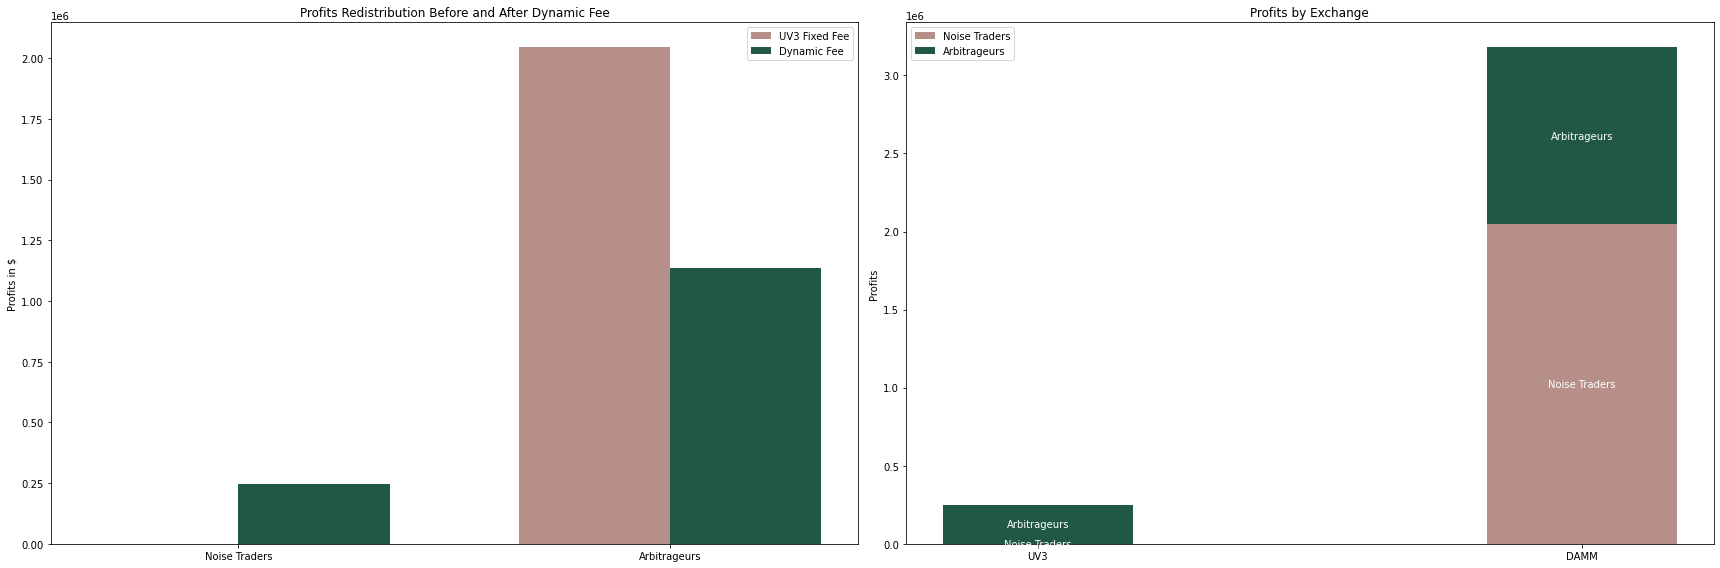

In [281]:
analyze_profit_redistribution(df_winsorize)


In [283]:

X = df['delta_p'].values.reshape(-1,1)
y_df = model_ols.predict(X)
df['f_dynamic_no_bound'] = np.array(y_df)
df['f_dynamic'] = df.apply(lambda row: calc_f_dynamic(row, f_min, f_max, intercept_constant), axis=1)

df['notional_profit'] = df.apply(lambda row: row['arb_profit_fixed']*row['amountUSD'], axis=1)
df['damm_fee'] = df.apply(lambda row: calc_damm_fee(row), axis=1)
# keep the index of sell orders, and convert delta_p to positive
index_sell_df = df[df['delta_p']<0].index
df['delta_p'] = df['delta_p'].abs()

df.loc[index_sell_df, 'delta_p'] = -df.loc[index_sell_df, 'delta_p']





In [272]:
df[(df['delta_p']<0) & (df['arb_profit_fixed']> 0)]['f_dynamic_no_bound'].describe()

count    3177.000000
mean       -0.001672
std         0.002710
min        -0.029491
25%        -0.001428
50%        -0.000932
75%        -0.000629
max        -0.000284
Name: f_dynamic_no_bound, dtype: float64

99.6037% of trades happen between ΔP in [-5,5], and Average Profits within ΔP [-5,5]: -3513.6586
98.9558% of trades happen between ΔP in [-2,2], and Average Profits within ΔP [-2,2]: -3193.0622
                     UV3                  DAMM                
------------------   ------------------   ------------------  
Arbitrageur Profit   2219906.3327628113   1472085.8532291246  
Noise Trader Profit  -10464079.510141138  -8180162.368077891  


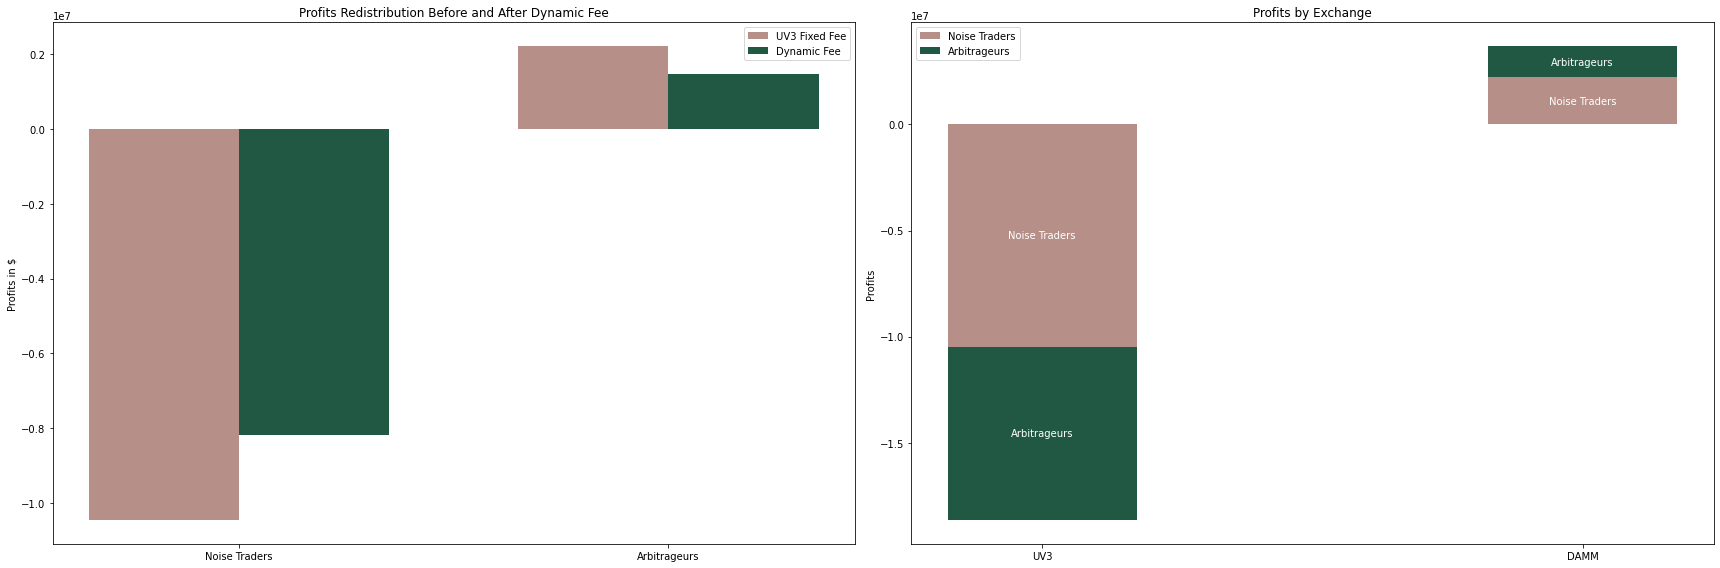

In [267]:
analyze_profit_redistribution(df)

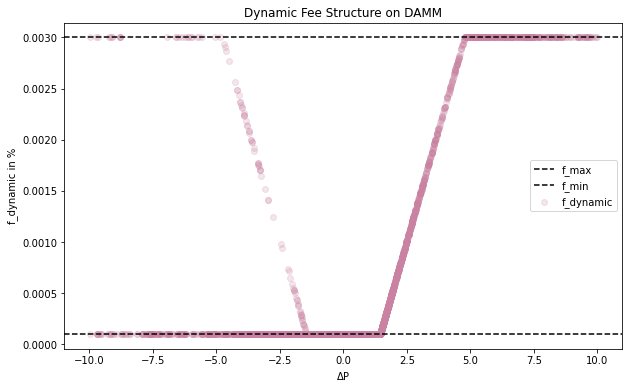

In [284]:
df_normal = df[(df['delta_p']>=-10)&(df['delta_p']<=10)]
plt.figure(figsize=(10, 6))
plt.scatter(df_normal['delta_p'], df_normal['f_dynamic'], color='#C982A1', alpha=0.2, label="f_dynamic")
plt.axhline(f_max, label='f_max', color='black', linestyle='--')
plt.axhline(f_min, label='f_min', color='black', linestyle='--')

plt.xlabel("$\Delta$P")
plt.ylabel("f_dynamic in %")
plt.legend()
plt.title("Dynamic Fee Structure on DAMM")
plt.show()

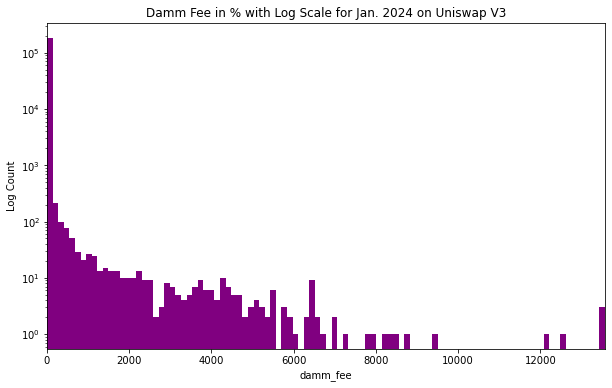

In [242]:
plt.figure(figsize=(10, 6))
plt.hist(df['damm_fee'], bins=100, log=True, color="purple")

locs, labels = plt.xticks()

# Set new labels reflecting the scaled x values without changing the data
# plt.xticks(locs, labels=[f"{100*loc:.2f}" for loc in locs])
plt.xlim(df['damm_fee'].min(), df['damm_fee'].max())
plt.xlabel('damm_fee')
plt.ylabel('Log Count')
plt.title('Damm Fee in % with Log Scale for Jan. 2024 on Uniswap V3')
plt.show()

In [243]:
print(f"{len(df[df['f_dynamic']==0.0001])/len(df)*100:.4f}% of the trades are charged minimum fee 1bps, compared to 5 bps")

99.1193% of the trades are charged minimum fee 1bps, compared to 5 bps


### Optimization for Shift



shift = 0.0001
----------------------------------------
99.6037% of trades happen between ΔP in [-5,5], and Average Profits within ΔP [-5,5]: -3513.6586
98.9558% of trades happen between ΔP in [-2,2], and Average Profits within ΔP [-2,2]: -3193.0622
                     UV3                  DAMM                
------------------   ------------------   ------------------  
Arbitrageur Profit   -15452.95534686034   -1818677.3324972633 
Noise Trader Profit  -11288821.978455042  -9230620.523598995  


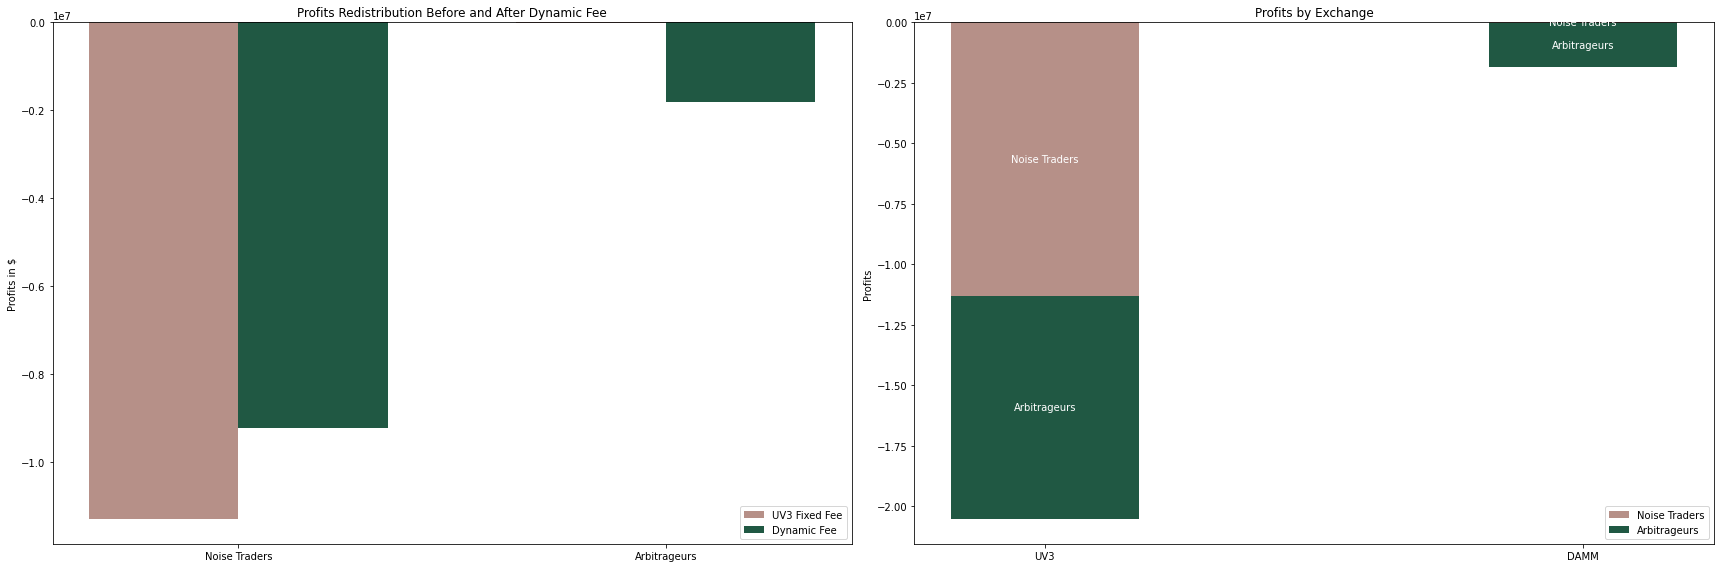



shift = 0.0002
----------------------------------------
99.6037% of trades happen between ΔP in [-5,5], and Average Profits within ΔP [-5,5]: -3513.6586
98.9558% of trades happen between ΔP in [-2,2], and Average Profits within ΔP [-2,2]: -3193.0622
                     UV3                  DAMM                
------------------   ------------------   ------------------  
Arbitrageur Profit   70974.02684499352    -1645823.368113556  
Noise Trader Profit  -11222300.732984552  -9097578.032658003  


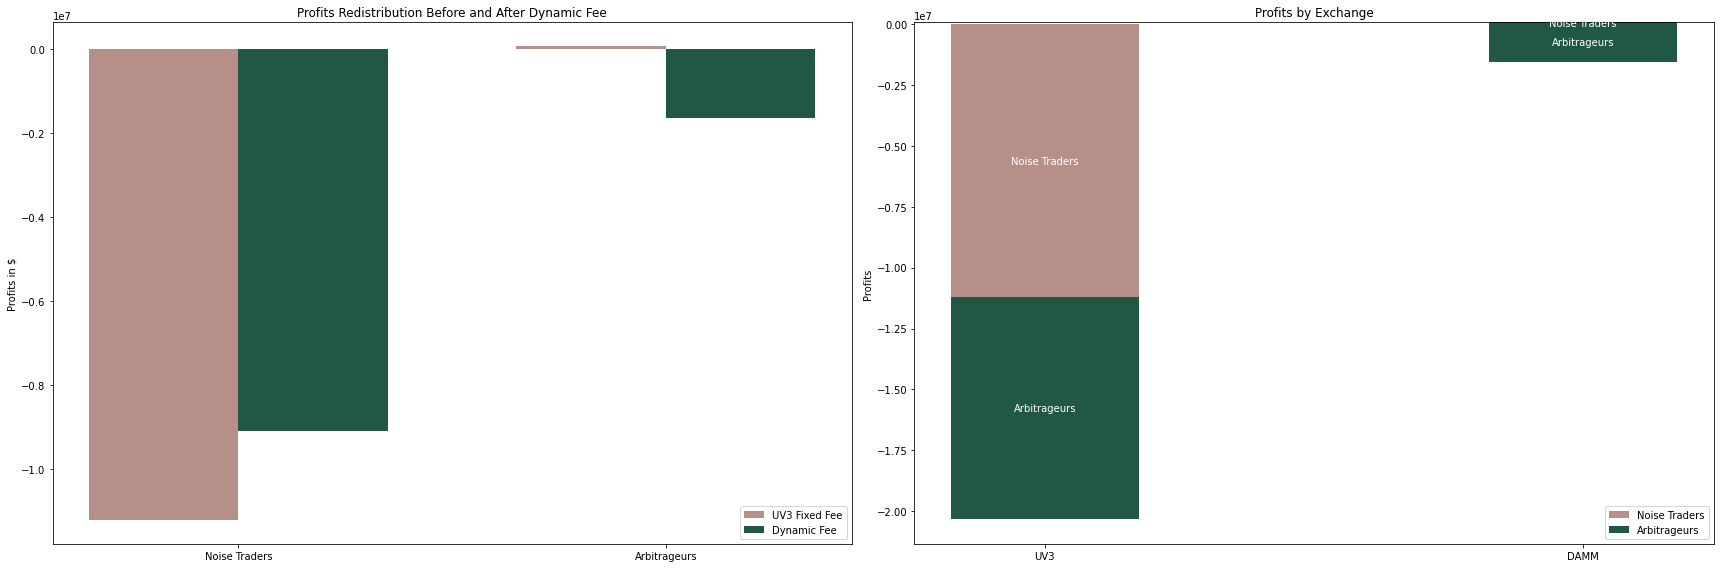



shift = 0.0003
----------------------------------------
99.6037% of trades happen between ΔP in [-5,5], and Average Profits within ΔP [-5,5]: -3513.6586
98.9558% of trades happen between ΔP in [-2,2], and Average Profits within ΔP [-2,2]: -3193.0622
                     UV3                  DAMM                
------------------   ------------------   ------------------  
Arbitrageur Profit   157401.00903684704   -1472969.403729849  
Noise Trader Profit  -11172053.762284085  -8997084.09125707   


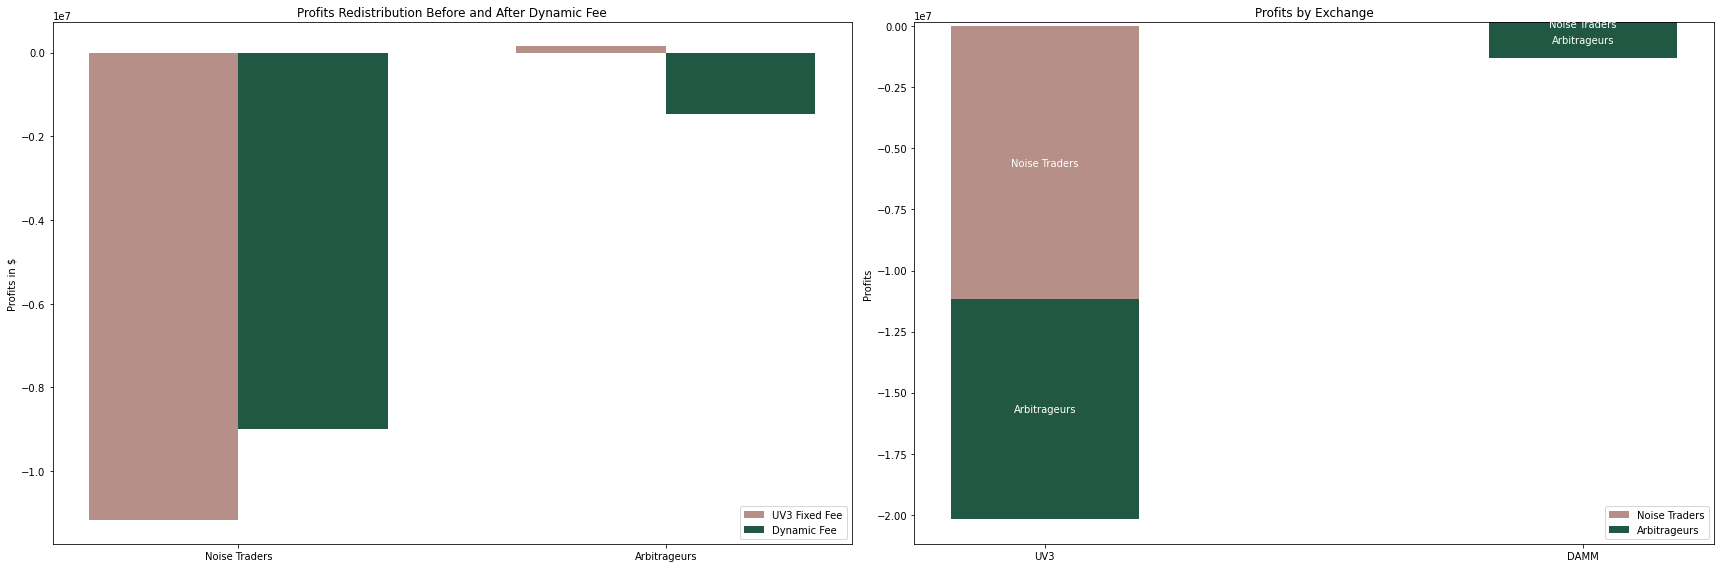



shift = 0.0004
----------------------------------------
99.6037% of trades happen between ΔP in [-5,5], and Average Profits within ΔP [-5,5]: -3513.6586
98.9558% of trades happen between ΔP in [-2,2], and Average Profits within ΔP [-2,2]: -3193.0622
                     UV3                  DAMM                
------------------   ------------------   ------------------  
Arbitrageur Profit   243827.9912287008    -1300115.4393461414 
Noise Trader Profit  -11134204.109908637  -8921384.786506172  


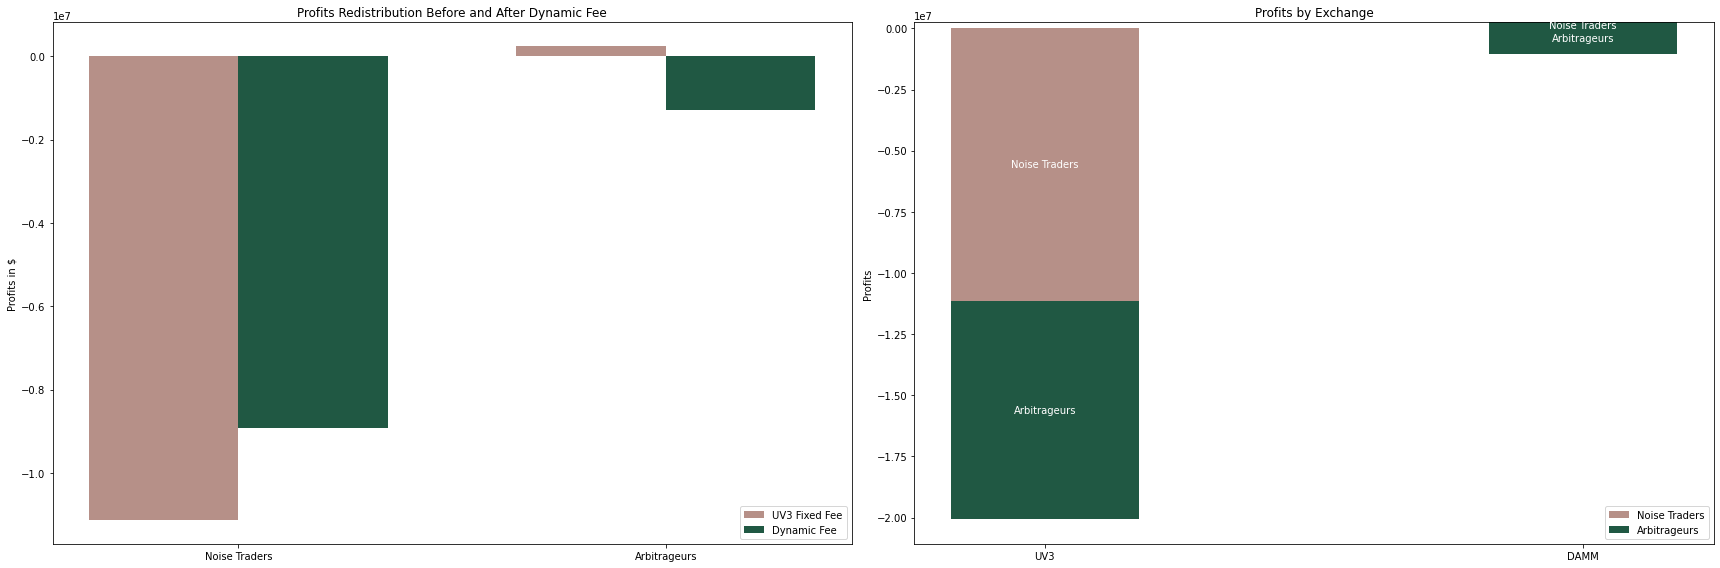



shift = 0.0005
----------------------------------------
99.6037% of trades happen between ΔP in [-5,5], and Average Profits within ΔP [-5,5]: -3513.6586
98.9558% of trades happen between ΔP in [-2,2], and Average Profits within ΔP [-2,2]: -3193.0622
                     UV3                  DAMM                
------------------   ------------------   ------------------  
Arbitrageur Profit   330254.97342055436   -1127261.4749624343 
Noise Trader Profit  -11104985.277152231  -8862947.120993368  


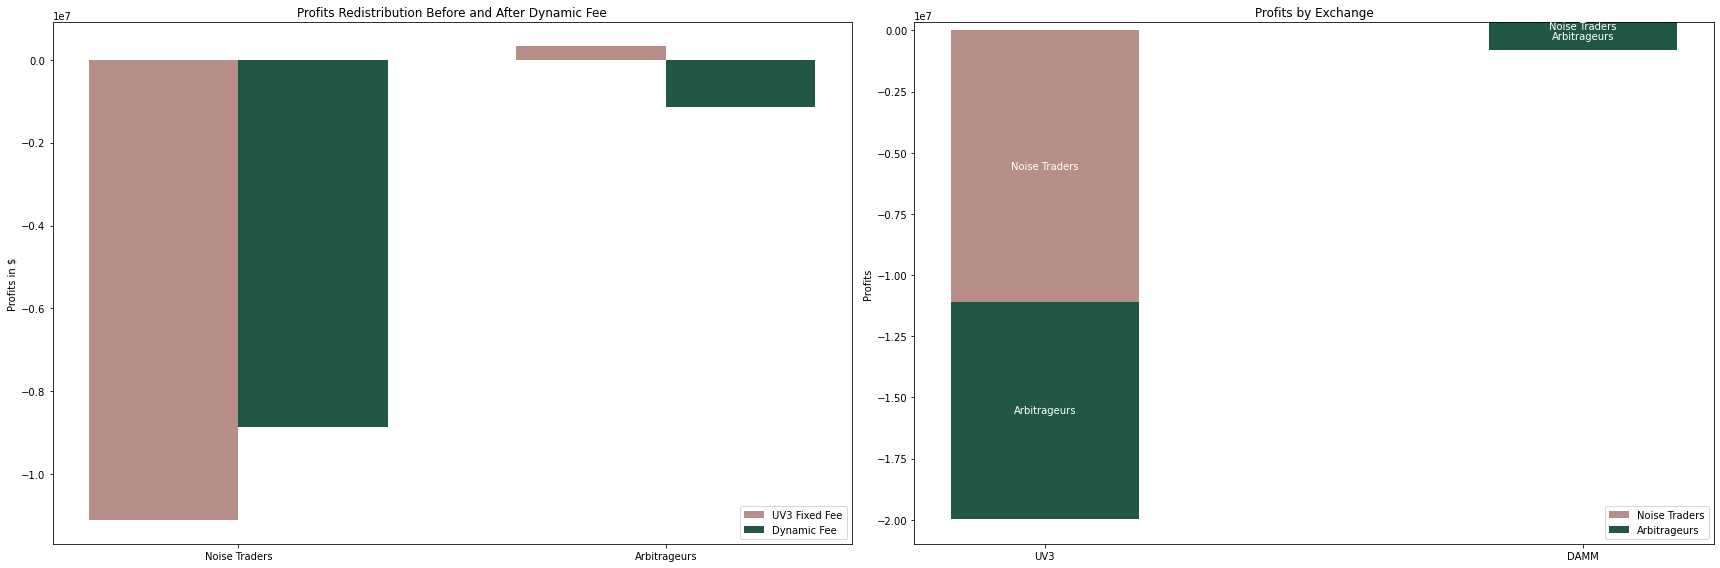



shift = 0.0008
----------------------------------------
99.6037% of trades happen between ΔP in [-5,5], and Average Profits within ΔP [-5,5]: -3513.6586
98.9558% of trades happen between ΔP in [-2,2], and Average Profits within ΔP [-2,2]: -3193.0622
                     UV3                  DAMM                
------------------   ------------------   ------------------  
Arbitrageur Profit   589535.9199961151    -608699.5818113127  
Noise Trader Profit  -11053769.216092318  -8760514.998873541  


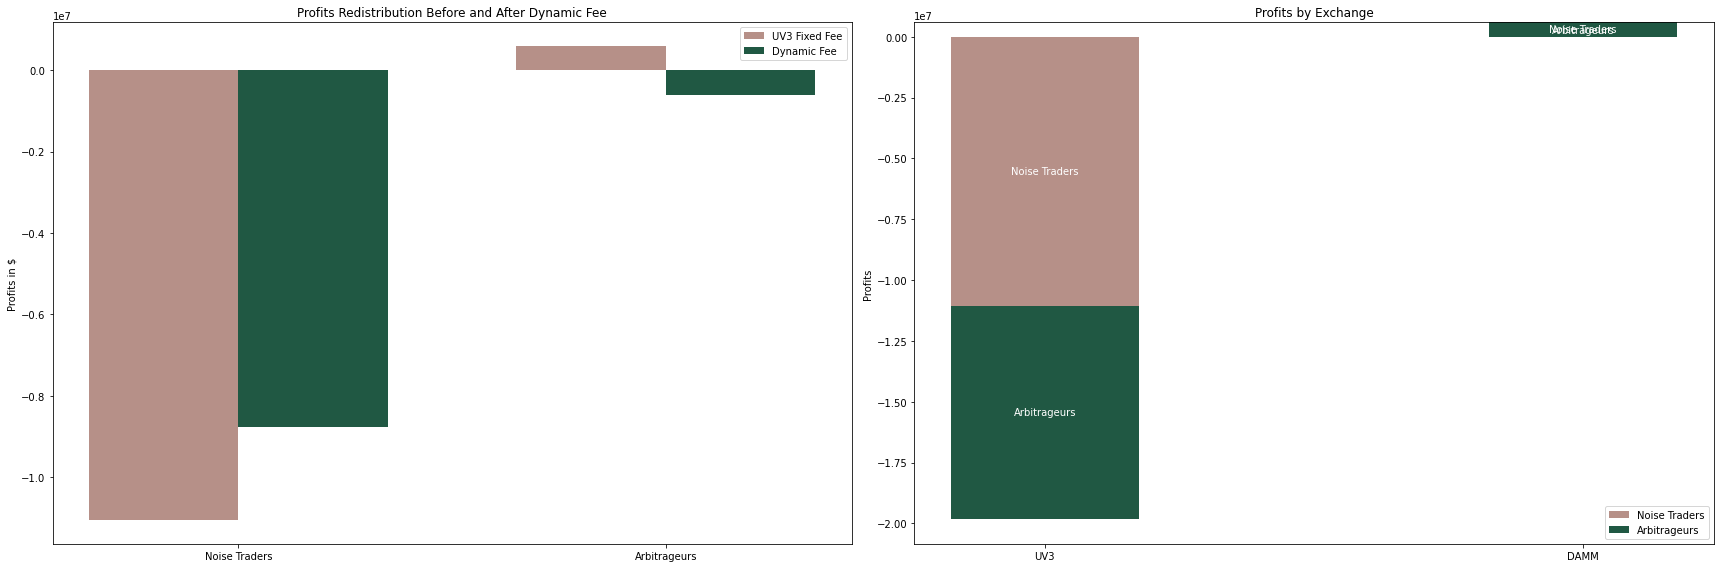

In [739]:
shifts = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0008]
# shifts = [0.0001]
for shift in shifts:
    boo = df.copy()
    boo['f_dynamic']=boo.apply(lambda row: calc_f_dynamic(row, f_min, f_max, shift), axis=1)
    boo['notional_profit']=boo.apply(lambda row: calc_damm_notional_profit(row), axis=1)
    print('\n')
    print(f'shift = {shift}')
    print('----------------------------------------')
    analyze_profit_redistribution(boo)
    

<Figure size 720x432 with 0 Axes>

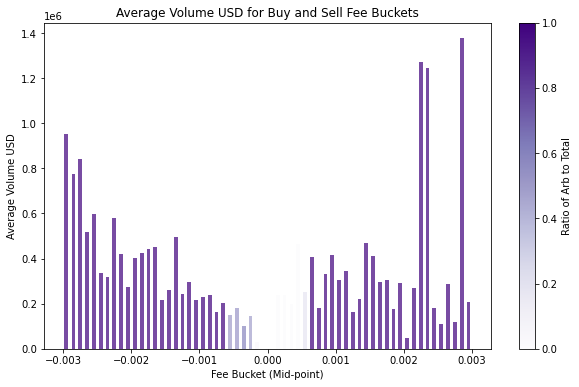

In [120]:
df1=df.copy()

# separate buy and sell
df1['f_dynamic']=df1.apply(lambda row: -row['f_dynamic'] if row['amount1']>0 else row['f_dynamic'], axis=1)
# Adjusting bins to a higher value for finer granularity
df1['fee_bucket'] = pd.cut(df1['f_dynamic'], bins=60)  # Adjusted number of bins from 10 to 20

bucket_ratio = df1.groupby('fee_bucket')['is_arb'].mean().reset_index()
# Convert intervals to mid-points for plotting
bucket_ratio['fee_bucket_mid'] = bucket_ratio['fee_bucket'].apply(lambda x: x.mid).astype(float)

# Calculate the average 'volumeUSD' for each bucket
agg_metrics = df1.groupby('fee_bucket')['amountUSD'].mean().reset_index()
agg_metrics
# Convert intervals to mid-points for plotting
agg_metrics['fee_bucket_mid'] = agg_metrics['fee_bucket'].apply(lambda x: x.mid).astype(float)

# shady hack due to (] of the category
# Step 1: Add the amountUSD from (0.0, 0.0001] to (0.0001, 0.0002]
# Identify the rows to update and the value to add
value_to_add = agg_metrics.loc[agg_metrics['fee_bucket'] == pd.Interval(0.0, 0.0001, closed='right'), 'amountUSD'].sum()

# Update the target row
# agg_metrics.loc[agg_metrics['fee_bucket'] == pd.Interval(0.0001, 0.0002, closed='right'), 'amountUSD'] += value_to_add

# Step 2: Set the amountUSD in (0.0, 0.0001] to 0
agg_metrics.loc[agg_metrics['fee_bucket'] == pd.Interval(0.0, 0.0001, closed='right'), 'amountUSD'] = 0

# Map the ratio to a color
norm = Normalize(vmin=bucket_ratio['is_arb'].min(), vmax=bucket_ratio['is_arb'].max())
cmap = plt.get_cmap('Purples')
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.figure(figsize=(10, 6))
# Plot using the mid-point of each fee bucket interval
# plt.bar(agg_metrics['fee_bucket_mid'], agg_metrics['amountUSD'].astype('float'), alpha=0.7, color='#7e6eb0', width=np.min(np.diff(agg_metrics['fee_bucket_mid']))/1.8)

plt.figure(figsize=(10, 6))
for idx, row in agg_metrics.iterrows():
    color = sm.to_rgba(bucket_ratio.loc[idx, 'is_arb'])
    plt.bar(row['fee_bucket_mid'], row['amountUSD'], alpha=0.7, color=color, width=np.min(np.diff(agg_metrics['fee_bucket_mid']))/1.8)

plt.colorbar(sm, label='Ratio of Arb to Total')

plt.title('Average Volume USD for Buy and Sell Fee Buckets')
plt.xlabel('Fee Bucket (Mid-point)')
plt.ylabel('Average Volume USD')

plt.show()

In [43]:
agg_metrics['fee_bucket']

0     (-0.00301, -0.0029]
1      (-0.0029, -0.0028]
2      (-0.0028, -0.0027]
3      (-0.0027, -0.0026]
4      (-0.0026, -0.0025]
5      (-0.0025, -0.0024]
6      (-0.0024, -0.0023]
7      (-0.0023, -0.0022]
8      (-0.0022, -0.0021]
9       (-0.0021, -0.002]
10      (-0.002, -0.0019]
11     (-0.0019, -0.0018]
12     (-0.0018, -0.0017]
13     (-0.0017, -0.0016]
14     (-0.0016, -0.0015]
15     (-0.0015, -0.0014]
16     (-0.0014, -0.0013]
17     (-0.0013, -0.0012]
18     (-0.0012, -0.0011]
19      (-0.0011, -0.001]
20      (-0.001, -0.0009]
21     (-0.0009, -0.0008]
22     (-0.0008, -0.0007]
23     (-0.0007, -0.0006]
24     (-0.0006, -0.0005]
25     (-0.0005, -0.0004]
26     (-0.0004, -0.0003]
27     (-0.0003, -0.0002]
28     (-0.0002, -0.0001]
29         (-0.0001, 0.0]
30          (0.0, 0.0001]
31       (0.0001, 0.0002]
32       (0.0002, 0.0003]
33       (0.0003, 0.0004]
34       (0.0004, 0.0005]
35       (0.0005, 0.0006]
36       (0.0006, 0.0007]
37       (0.0007, 0.0008]
38       (0.

## New Optimization

In [124]:
shift = 0.001

# print(f"{len(df[df['damm_fee']==0])/len(df)*100:.4f}% of the user will leave the pool")

# maximize total damm fee
def objective(x, df):
    df['f_dynamic']=df.apply(lambda row: calc_f_dynamic(row, f_min, f_max, x), axis=1)
    df['damm_fee'] = df.apply(lambda row: calc_damm_fee(row, 0.5, 1), axis=1)
    return -df['damm_fee'].sum() # Negate because we are minimizing

# Initial guess for x
x0 = np.array([0.001])

# Bounds for x, if any
bounds = [(0, 0.05)]
result = minimize(lambda x: objective(x, df), x0, bounds=bounds, method='slsqp')

# Results
if result.success:
    optimized_x = result.x
    print("Optimized parameter x:", optimized_x)
    print("Maximized LP profits:", -result.fun)  # Negate because we minimized the negative profits
else:
    print("Optimization failed:", result.message)


Optimized parameter x: [0.001]
Maximized LP profits: 95158.3878252385


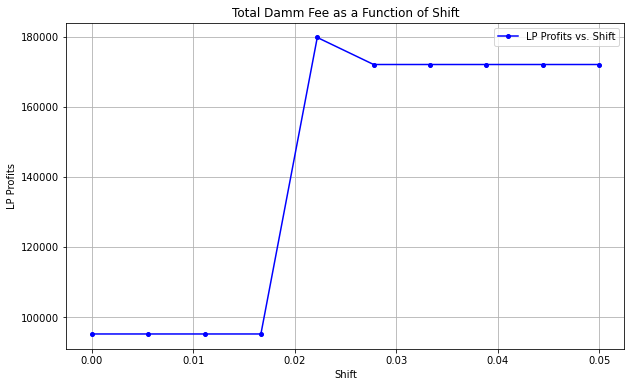

In [127]:
# Generate a range of shift values for visualization
shift_values = np.linspace(0, 0.05, 10)  # Adjust range and number of points as needed

# c1, c2 are positive floats 
def calc_damm_fee_complex(row, c1, c2):
    new_fee = row['f_dynamic']*row['amountUSD']
    original_profit = row['notional_profit'] - row['pool_fee']
    new_profit = row['notional_profit'] - new_fee
    # when trader has positive profits, they will leave if their new profits are e.g. 50% (using c1) of what it used to be
    if original_profit >= 0 and new_profit < c1 * original_profit:
        new_fee = 0
    # when trader has negative profits in uv3, they will leave if their new profits are twice (using c2) as negative
    if original_profit < 0 and new_profit < c2 * original_profit:
        new_fee = 0

    return new_fee

# maximize total damm fee
def objective(x, df):
    df['f_dynamic']=df.apply(lambda row: calc_f_dynamic(row, f_min, f_max, x), axis=1)
    df['damm_fee'] = df.apply(lambda row: calc_damm_fee_complex(row, 0.5, 1), axis=1)
    return -df['damm_fee'].sum() # Negate because we are minimizing

# Initialize a list to store the LP profits for each shift value
damm_fees = []

# Calculate LP profits for each shift value
for shift in shift_values:
    profit = objective(shift, df)  # Assuming these variables are defined and accessible
    damm_fees.append(-profit)  # Negating to convert back to profit from minimized objective

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(shift_values, damm_fees, '-o', color='blue', markersize=4, label='LP Profits vs. Shift')
plt.title('Total Damm Fee as a Function of Shift')
plt.xlabel('Shift')
plt.ylabel('LP Profits')
plt.grid(True)
plt.legend()
plt.show()